Based on and follows the license of the source code for:

```
Shvets, A.A., Iglovikov, V.I., Rakhlin, A. and Kalinin, A.A., 2018, December. Angiodysplasia detection and localization using deep convolutional neural networks. In 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 612-617). IEEE.
```

https://github.com/alxndrkalinin/angiodysplasia-segmentation

## Imports

In [1]:
import os
import import_ipynb
from functools import partial
import pickle
%matplotlib inline
from pylab import *
import cv2
from PIL import Image

import torch
from torch import nn
from torchvision import models
from torchvision.transforms import ToTensor, Normalize, Compose, CenterCrop, ColorJitter

In [2]:
from utils import cuda, variable, mask_overlay, summary, UNet

importing Jupyter notebook from utils.ipynb


## Defaults

In [3]:
rel_path = os.path.join(os.environ['HOME'], 'shared', 'c14_files')

# model weight files
UNET_WEIGHTS = os.path.join(rel_path, 'unet.pt')
VGG11_WEIGHTS = os.path.join(rel_path, 'vgg11.pt')
VGG16_WEIGHTS = os.path.join(rel_path, 'vgg16.pt')
LINKNET34_WEIGHTS = os.path.join(rel_path, 'linknet34.pt')

# local example image
EXAMPLE_IMAGE = os.path.join(rel_path, 'angiodysplasia_example.png')

# binary segmentation
NUM_CLASSES = 1

## Example image

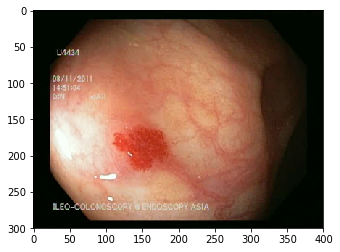

In [4]:
# example_image_path = "https://4.bp.blogspot.com/-bjpXM6-YE_c/UoyZbqbE0LI/AAAAAAAAAPM/6AsVvUQNbhg/s400/1.Classical+angiodysplasia+seen+in+caecum.png"
# !wget -q -O "$EXAMPLE_IMAGE" --no-check-certificate "$example_image_path"
img = Image.open(EXAMPLE_IMAGE).convert('RGB')
imshow(img)


In [5]:
# define image transforms
img_transform = Compose([
#     ColorJitter(brightness=0.5, contrast=0.5),
    CenterCrop((320,320)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Loading a pre-trained model

In [6]:
def get_model(Model, model_path, num_classes):
    
    # get instance of the model
    model = Model(num_classes=num_classes)
    
    # load pre-trained weights
    state = torch.load(str(model_path), map_location='cpu')
    state = {key.replace('module.', ''): value for key, value in state['model'].items()}
    model.load_state_dict(state)

    if torch.cuda.is_available():
        return model.cuda()

    model.eval()
    return model

## U-Net model

In [7]:
model = get_model(UNet,
                  UNET_WEIGHTS,
                  num_classes=NUM_CLASSES)
# model

## Predict on sample image with U-Net

In [8]:
# predict
with torch.no_grad():
  input_img = torch.unsqueeze(variable(img_transform(img)), dim=0)
  unet_mask = model(input_img)

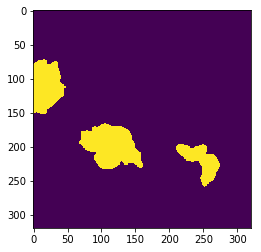

In [9]:
# show predicted mask
unet_mask_array = unet_mask.data[0].cpu().numpy()[0]
imshow(unet_mask_array > 0)

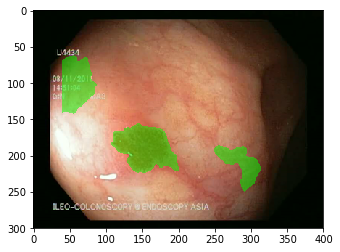

In [10]:
# show mask-on-image overlay
imshow(mask_overlay(img, (unet_mask_array > 0).astype(np.uint8)))

## U-Net with VGG encoders (aka TernausNet)

As an improvement over the standard U-Net architecture, we use similar networks with pre-trained encoders. TernausNet is a U-Net-like architecture that uses relatively simple pre-trained VGG-11 or VGG-16 networks as an encoder. VGG-11 consists of seven convolutional layers, each followed by a ReLU activation function, and five max polling operations, each reducing feature map by 2. All convolutional layers have 3 × 3 kernels. TernausNet-16 has a similar structure and uses VGG-16 network as an encoder.

![VGG-16](vgg11.png)
![TernausNet](ternausnet16_sm.png)

## Implementing TernausNet-11

In [11]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)

In [12]:
class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            vgg - encoder pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.num_classes = num_classes

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[3],
                                   self.relu)

        self.conv3 = nn.Sequential(
            self.encoder[6],
            self.relu,
            self.encoder[8],
            self.relu,
        )
        self.conv4 = nn.Sequential(
            self.encoder[11],
            self.relu,
            self.encoder[13],
            self.relu,
        )

        self.conv5 = nn.Sequential(
            self.encoder[16],
            self.relu,
            self.encoder[18],
            self.relu,
        )

        self.center = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 4, is_deconv=is_deconv)
        self.dec3 = DecoderBlock(256 + num_filters * 4, num_filters * 4 * 2, num_filters * 2, is_deconv=is_deconv)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))
        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [13]:
model = get_model(UNet11,
                  VGG11_WEIGHTS,
                  num_classes=NUM_CLASSES)

In [14]:
with torch.no_grad():
  input_img = torch.unsqueeze(variable(img_transform(img)), dim=0)
  vgg11_mask = model(input_img)

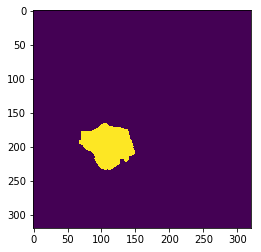

In [15]:
# show predicted mask
vgg11_mask_array = vgg11_mask.data[0].cpu().numpy()[0]
imshow(vgg11_mask_array > 0)

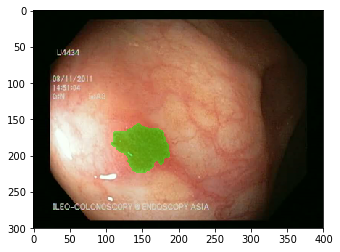

In [16]:
# show mask-on-image overlay
imshow(mask_overlay(img, (vgg11_mask_array > 0).astype(np.uint8)))

## U-Net with VGG-16 encoder

In [17]:
class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained: if encoder uses pre-trained weigths from VGG16
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv=is_deconv)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [18]:
model = get_model(UNet16,
                  VGG16_WEIGHTS,
                  num_classes=NUM_CLASSES)

In [19]:
with torch.no_grad():
  input_img = torch.unsqueeze(variable(img_transform(img)), dim=0)
  vgg16_mask = model(input_img)

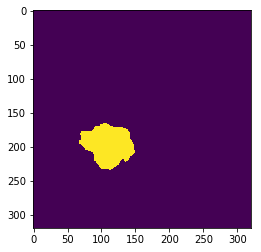

In [20]:
# show predicted mask
vgg16_mask_array = vgg16_mask.data[0].cpu().numpy()[0]
imshow(vgg16_mask_array > 0)

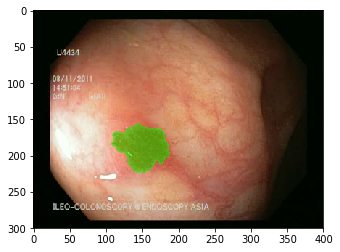

In [21]:
# show mask-on-image overlay
imshow(mask_overlay(img, (vgg16_mask_array > 0).astype(np.uint8)))

## LinkNet with ResNet-34 encoder (aka AlbuNet-34)

AlbuNet uses an encoder based on a ResNet-type architecture. In this work, we use pre-trained ResNet-34. The encoder starts with the initial block that performs convolution with a kernel of size 7×7 and stride 2. This block is followed by max-pooling with stride 2. The later portion of the network consists of repetitive residual blocks. In every residual block, the first convolution operation is implemented with stride 2 to provide downsampling, while the rest convolution operations use stride 1. In addition, the decoder of the network consists of several decoder blocks that are connected with the corresponding encoder block. As for TernausNets, the transmitted block from the encoder is concatenated to the corresponding decoder block. Each decoder block includes 1 × 1 convolution operation that reduces the number of filters by 4, followed by batch normalization and transposed convolution to upsample the feature map.

![ResNet-34](resnet34.png)
![LinkNet-34](LinkNet34_sm.png)

In [22]:
class LinkNet34(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlock(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlock(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlock(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out

In [23]:
model = get_model(LinkNet34,
                  LINKNET34_WEIGHTS,
                  num_classes=NUM_CLASSES)

In [24]:
with torch.no_grad():
  input_img = torch.unsqueeze(variable(img_transform(img)), dim=0)
  linknet34_mask = model(input_img)

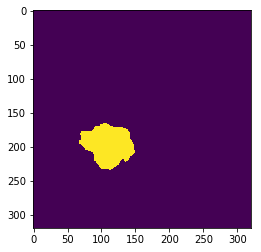

In [25]:
# show predicted mask
vgg16_mask_array = vgg16_mask.data[0].cpu().numpy()[0]
imshow(vgg16_mask_array > 0)

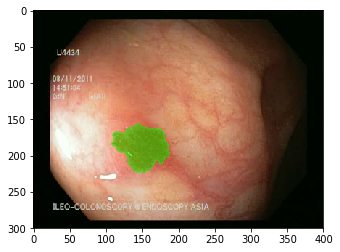

In [26]:
imshow(mask_overlay(img, (vgg16_mask_array > 0).astype(np.uint8)))